# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

# 📚 Basic Libraries
import pandas as pd
import numpy as np
import datetime as datetime

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 🔧 Basic functions
def snake_columns(data): 
    """
    returns the columns in snake case
    """
    data.columns = [column.lower().replace(' ', '_') for column in data.columns]
    
def open_data(data): # returns shape, data types & shows a small sample
    print(f"Data shape is {data.shape}.")
    print()
    print(data.dtypes)
    print()
    print("Data row sample and full columns:")
    return data.sample(5)

# 🎯 Specific functions
def explore_data(data): # sum & returns duplicates, NaN & empty spaces
    duplicate_rows = data.duplicated().sum()
    nan_values = data.isna().sum()
    empty_spaces = data.eq(' ').sum()
    nan_pct = round((data.isna().sum()/len(data)*100),2)
    import pandas as pd
    exploration = pd.DataFrame({"NaN": nan_values, "NaN %": nan_pct, "EmptySpaces": empty_spaces}) # New dataframe with the results
    print(f"There are {duplicate_rows} duplicate rows. Also;")
    return exploration

def outliers(data, threshold = 1.5, result = "outliers"): 
    """
    Identifies the outliers in each column and returns a dataframe with only the outliers.

    If the parameter result = "slayed" it returns the dataframe passed in without outliers
    """
    import numpy as np
    import pandas as pd
    outliers=[]
    for column in data.select_dtypes(include=[np.number]):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        if result == "slayed":
            data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
        else:
            outliers.append(data[(data[column] < lower_bound) | (data[column] > upper_bound)])
    if result == "slayed":
        return data
    else:
        outliers_df = pd.concat(outliers).drop_duplicates()
        return outliers_df


def evaluate_regresion_model(df, target, size=0.3, random=42, shuff=True, round_digits=4):
    """
    Function to automatically evaluate ML regresion models and returns a df with the comparison
    """
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    import xgboost as xgb
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
    import pandas as pd

    # Definition of the models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Decision Tree': DecisionTreeRegressor(),
        'KNN': KNeighborsRegressor(),
        'XGBoost': xgb.XGBRegressor()
        }

    metrics = {
        'Model': [],
        'R²': [],
        'RMSE': [],
        'MSE': [],
        'MAE': []
        }
    
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Separate data into train and test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = random, shuffle = shuff)

    #Run all the models and store the results
    for key, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        metrics['Model'].append(key)
        metrics['R²'].append(r2_score(y_test, predictions))
        metrics['RMSE'].append(root_mean_squared_error(y_test, predictions))
        metrics['MSE'].append(mean_squared_error(y_test, predictions))
        metrics['MAE'].append(mean_absolute_error(y_test, predictions))

    df_metrics = round(pd.DataFrame(metrics),round_digits)
    return df_metrics.set_index("Model").T

def range_verifier(value):
    return isinstance(value, range)

def evaluate_clasification_model(df, target, size=0.3, random=42, shuff=True, neighbors=3, trees=3):
    """
    Function to automatically evaluate ML clasification models and shows results.
    Parameters neighbors and tree can be:
     - integers to define the number of neighbors and depth of tree levels
     - ranges (ex. range(5, 30)) to tune the parameter
    """
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression 
    import xgboost as xgb
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
    import matplotlib.pyplot as plt

    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Separate data into train and test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = random, shuffle = shuff)

    # Determine the optimal number of neighbors if `neighbors` is a range
    if range_verifier(neighbors) == False:
        num_neighbors = neighbors
    else:
        n_test = {}
        for neighbor in neighbors:
            model = KNeighborsClassifier(n_neighbors=neighbor)
            model.fit(X_train, y_train)
            n_test[neighbor] = model.score(X_test,y_test)
        num_neighbors = max(n_test, key=n_test.get)

    # Determine the optimal tree depth if `trees` is a range
    if range_verifier(trees) == False:
        num_trees = trees
    else:
        t_test = {}
        for tree in trees:
            model = DecisionTreeClassifier(max_depth=tree)
            model.fit(X_train, y_train)
            t_test[tree] = model.score(X_test,y_test)
        num_trees = max(t_test, key=t_test.get)

    # Definition of the models
    models = {
        'Logistic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(n_neighbors=num_neighbors),
        'Decision Tree': DecisionTreeClassifier(max_depth=num_trees),
        'SVM': LinearSVC(),
        'XGBoost': xgb.XGBClassifier()
        }
    
    #Run all the models and store the results
    for key, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("\n---------------------------------------------------\n")
        print(key) # Print the model name
        if key == "KNN":
            print(f"with {num_neighbors} neighbors")
        elif key == "Decision Tree":
            print(f"with {num_trees} maximum depth")
        
        print(classification_report(y_test, predictions)) # Print the model clasification report
        
        # Print the acurracy of test and train
        print("Test data accuracy: ",model.score(X_test,y_test))
        print("Train data accuracy: ", model.score(X_train, y_train))
        
        # Calculate and displays the confusion matrix
        cm = confusion_matrix(y_test, predictions)
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        plt.figure(figsize=(8, 6))
        disp.plot(cmap='Oranges')
        if key == "KNN":
            plt.title(f'{key} Confusion Matrix with {num_neighbors} neighbors')
        elif key == "Decision Tree":
            plt.title(f'{key} Confusion Matrix with {num_trees} maximum depth')
        else:
            plt.title(f'{key} Confusion Matrix')
        plt.grid(False)
        plt.show()

        # Calculate and displays the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{key} Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(False)
        plt.show()

def correlation_matrix(df):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    data = df.select_dtypes(include=[np.number])
    num_corr = round(data.corr(), 2)
    # Correlation Matrix-Heatmap Plot
    mask = np.zeros_like(num_corr)
    mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

    f, ax = plt.subplots(figsize=(25, 15))
    sns.set(font_scale=1.5) # increase font size

    ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
    ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
    plt.show()

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [3]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [4]:
snake_columns(websites)
open_data(websites)

Data shape is (1781, 21).

url                           object
url_length                     int64
number_special_characters      int64
charset                       object
server                        object
content_length               float64
whois_country                 object
whois_statepro                object
whois_regdate                 object
whois_updated_date            object
tcp_conversation_exchange      int64
dist_remote_tcp_port           int64
remote_ips                     int64
app_bytes                      int64
source_app_packets             int64
remote_app_packets             int64
source_app_bytes               int64
remote_app_bytes               int64
app_packets                    int64
dns_query_times              float64
type                           int64
dtype: object

Data row sample and full columns:


,url,url_length,number_special_characters,charset,server,content_length,whois_country,whois_statepro,whois_regdate,whois_updated_date,...,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type
822,M0_146,48,11,UTF-8,nginx,640.0,NaN,NaN,NaN,NaN,...,1,4,2912,31,25,3753,3494,31,8.0,1
728,B0_730,45,9,iso-8859-1,nginx,NaN,US,WA,20/07/1998 4:00,21/02/2017 3:57,...,0,2,805,12,11,1087,1099,12,4.0,0
1509,M4_72,82,17,utf-8,Microsoft-IIS/6.0,NaN,US,California,18/06/2003 0:00,14/06/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
287,B0_144,35,6,us-ascii,Microsoft-IIS/7.5,324.0,NaN,NaN,21/03/2014 0:00,22/03/2017 0:00,...,15,8,1527,24,25,1928,1699,24,2.0,0
1386,B0_1371,71,13,UTF-8,Server,NaN,US,NV,1/11/1994 0:00,30/04/2014 0:00,...,0,0,0,0,0,0,0,0,0.0,0


In [5]:
websites.type.value_counts()

type
0    1565
1     216
Name: count, dtype: int64

In [6]:
"""
The target column is type, the rest are features
In column type (target):
    - 0 means beningn
    - 1 means malign
We have to transform whois_regdate & whois_updated_date to ordinal
"""

'\nThe target column is type, the rest are features\nIn column type (target):\n    - 0 means beningn\n    - 1 means malign\nWe have to transform whois_regdate & whois_updated_date to ordinal\n'

#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

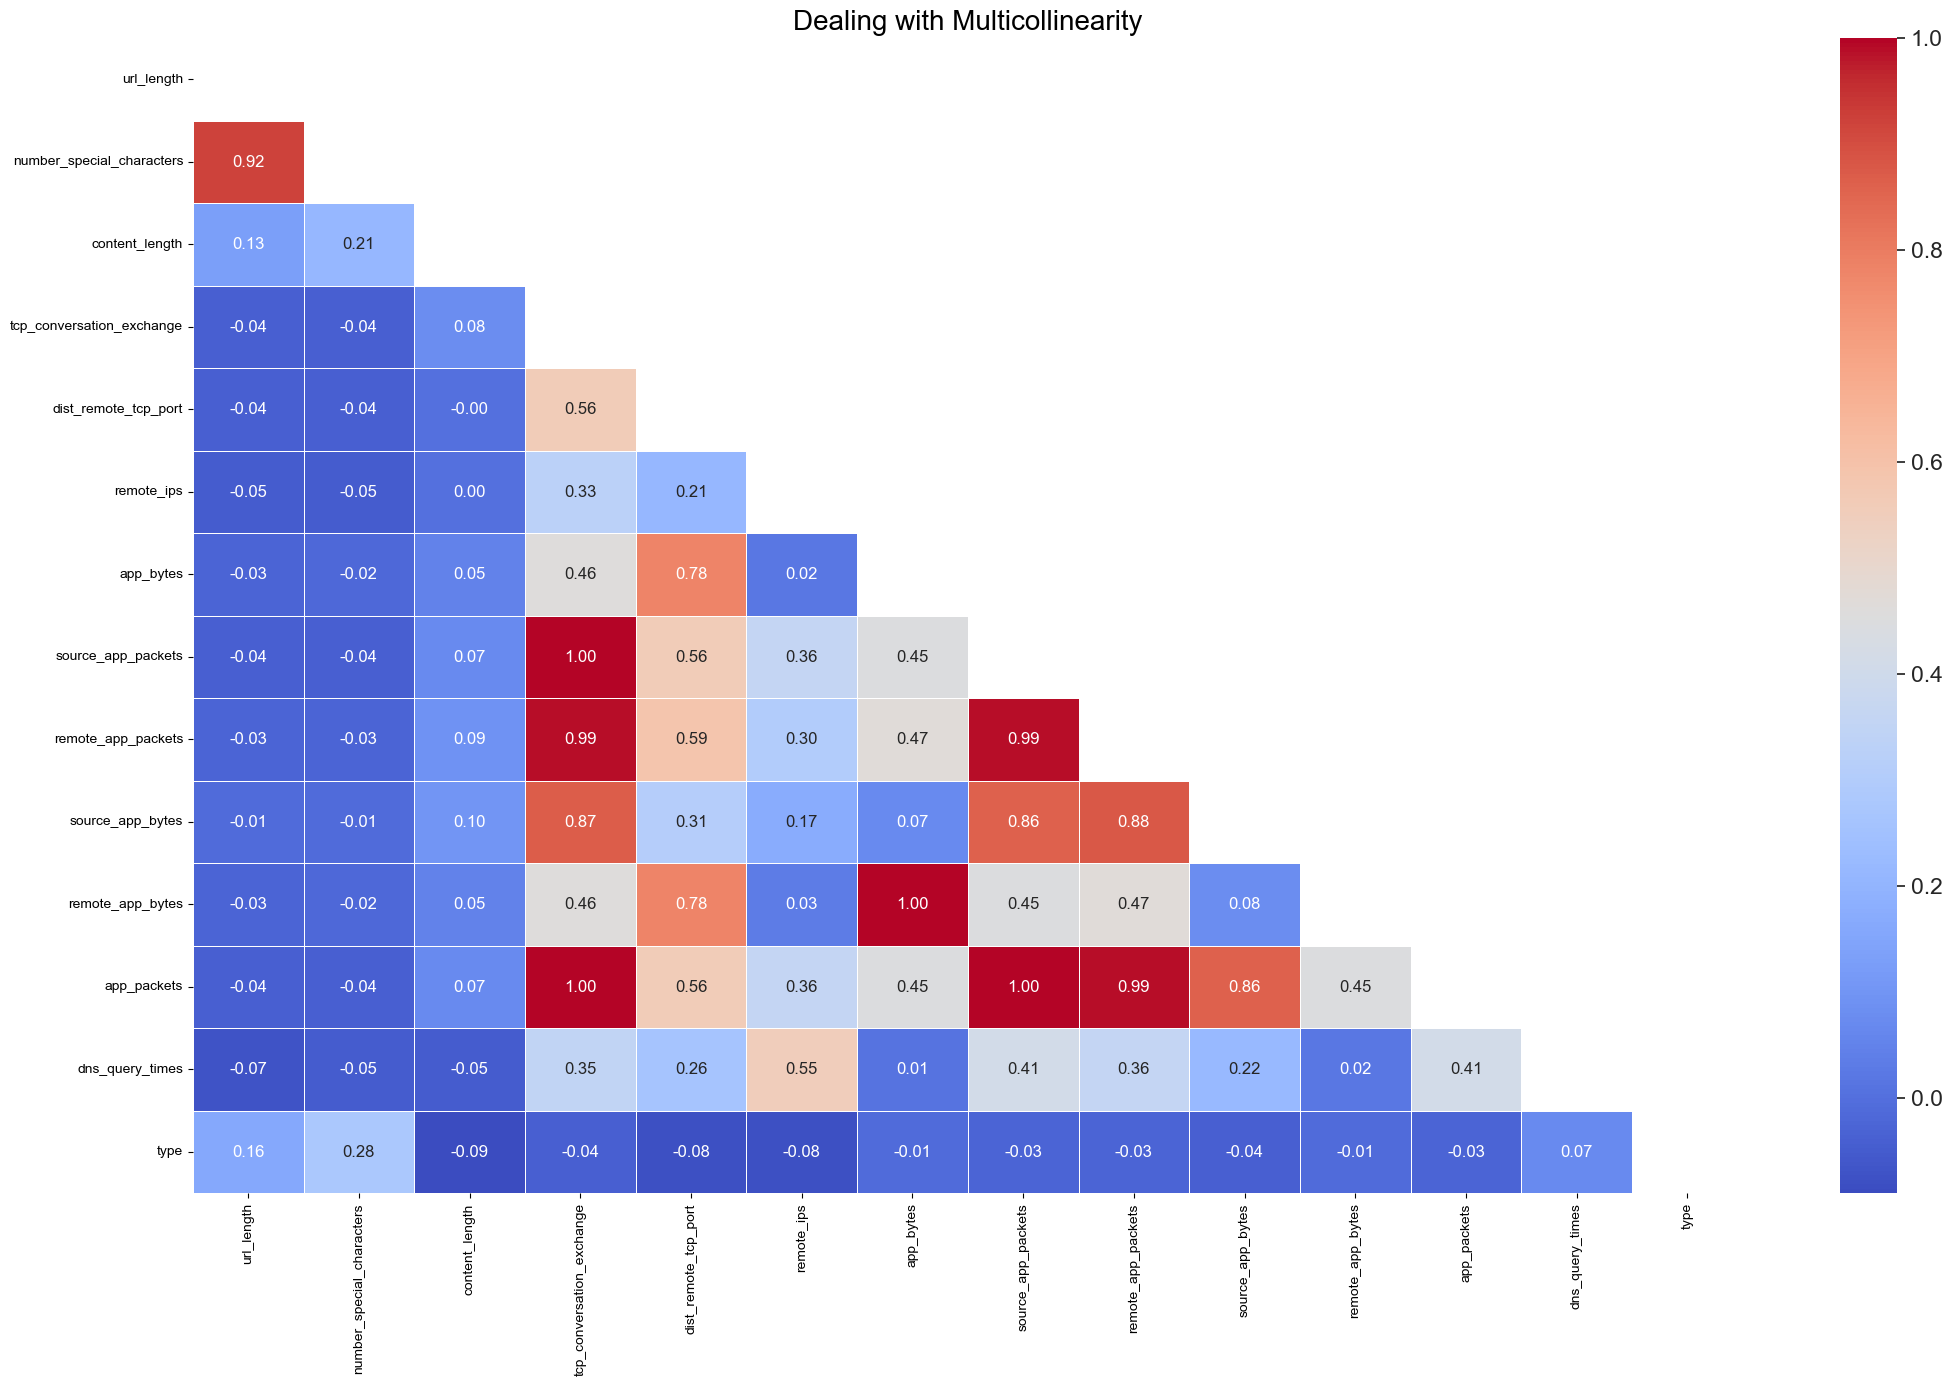

In [7]:
correlation_matrix(websites)

In [8]:
# We have to drop: url_length, source_app_packets, remote_app_packets, app_packets, remote_app_bytes

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [9]:
df2 = websites.drop(columns=["url_length", "source_app_packets", "remote_app_packets", "app_packets", "remote_app_bytes"])

In [10]:
#from the column pairs that have colinearity (over 0.9) we remove the ones that have less correlation with the target 

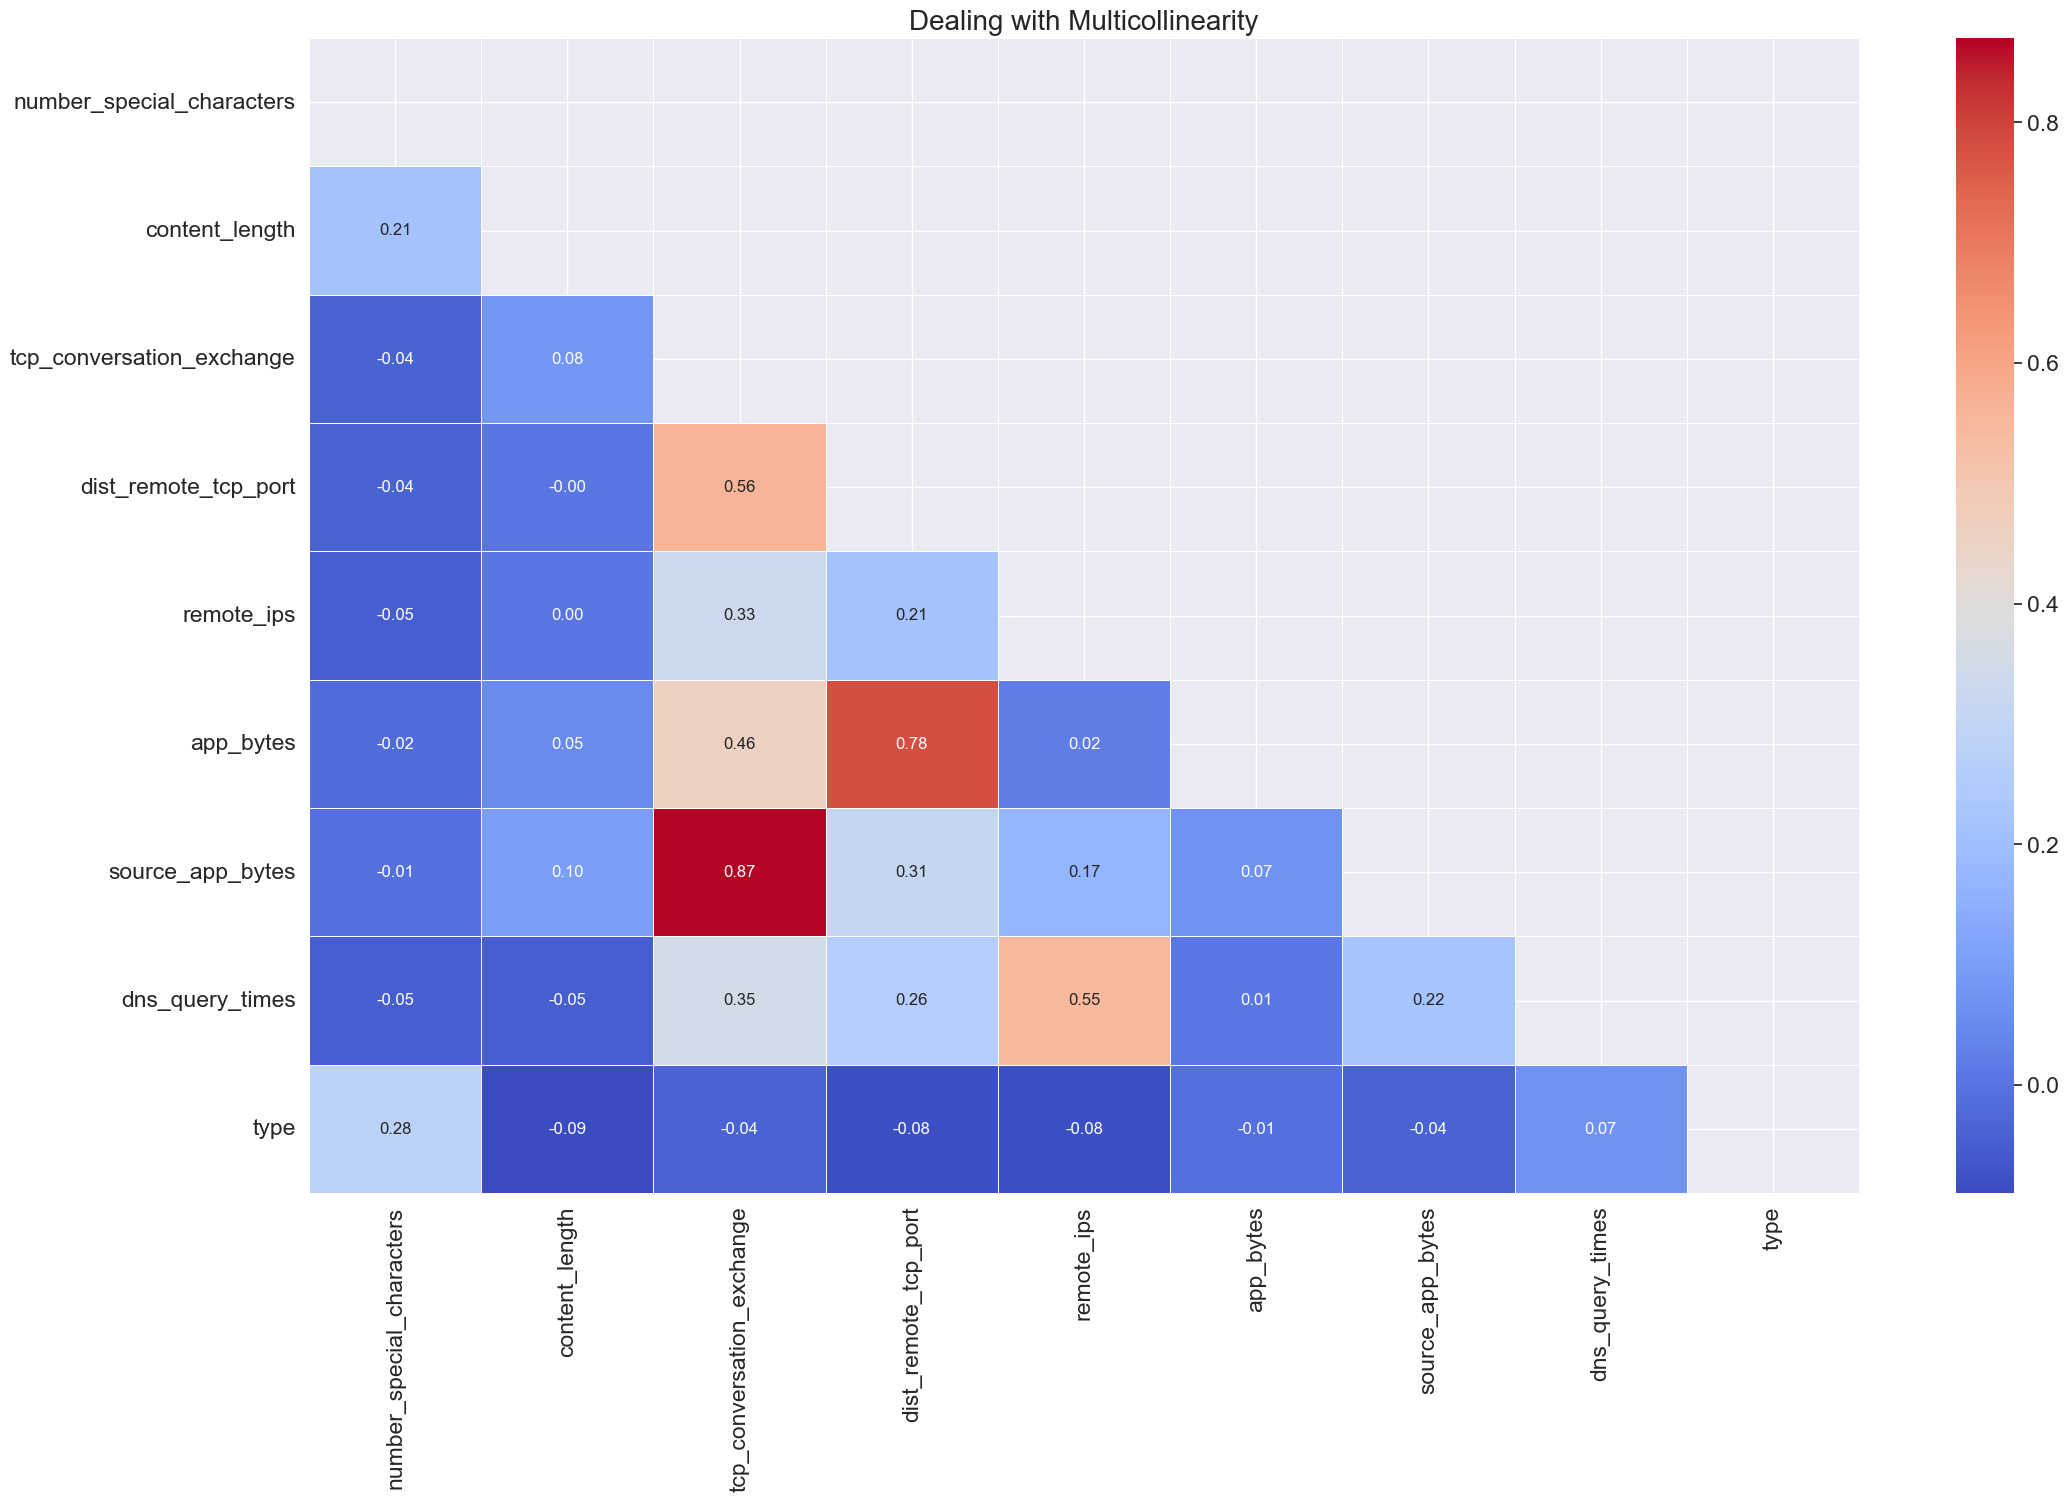

In [11]:
correlation_matrix(df2)

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [12]:
explore_data(df2)

There are 0 duplicate rows. Also;


,NaN,NaN %,EmptySpaces
url,0,0.00,0
number_special_characters,0,0.00,0
charset,7,0.39,0
server,176,9.88,0
content_length,812,45.59,0
whois_country,306,17.18,0
whois_statepro,362,20.33,0
whois_regdate,127,7.13,0
whois_updated_date,139,7.80,0
tcp_conversation_exchange,0,0.00,0


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [13]:
df2.drop(columns=["content_length"], inplace=True)

In [14]:
df2["dns_query_times"].interpolate(inplace=True)

C:\Users\FernandoSanz-Extreme\AppData\Local\Temp\ipykernel_45072\2509464592.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["dns_query_times"].interpolate(inplace=True)


In [15]:
for column in df2.select_dtypes(exclude=[np.number]):
    df2[column] = df2[column].fillna("unkown")

In [16]:
# We have dropped the column with almost half of missing values, we have interpolated the missing value of dns_query_times.
# We have filled the NaNs of the categorical columns with "Unknown"

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [17]:
# Examine missing values in each column
explore_data(df2)

There are 0 duplicate rows. Also;


,NaN,NaN %,EmptySpaces
url,0,0.0,0
number_special_characters,0,0.0,0
charset,0,0.0,0
server,0,0.0,0
whois_country,0,0.0,0
whois_statepro,0,0.0,0
whois_regdate,0,0.0,0
whois_updated_date,0,0.0,0
tcp_conversation_exchange,0,0.0,0
dist_remote_tcp_port,0,0.0,0


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [18]:
df2["whois_country"].replace(["[u'GB'; u'UK']", "United Kingdom", "GB"], "UK", inplace=True)
df2["whois_country"].replace("CYPRUS", "CY", inplace=True)
df2["whois_country"] = df2["whois_country"].str.upper()
df2["whois_country"].value_counts()

C:\Users\FernandoSanz-Extreme\AppData\Local\Temp\ipykernel_45072\4226028702.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["whois_country"].replace(["[u'GB'; u'UK']", "United Kingdom", "GB"], "UK", inplace=True)


whois_country
US        1106
UNKOWN     306
CA          84
ES          63
UK          35
AU          35
PA          21
JP          11
CN          10
IN          10
FR           9
CZ           9
NL           6
CH           6
RU           6
KR           5
AT           4
SE           4
BS           4
PH           4
BE           3
HK           3
TR           3
DE           3
KY           3
SC           3
UA           2
CYPRUS       2
UY           2
KG           2
BR           2
NO           2
IL           2
SI           2
LV           1
PK           1
IT           1
LU           1
BY           1
AE           1
IE           1
UG           1
TH           1
Name: count, dtype: int64

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

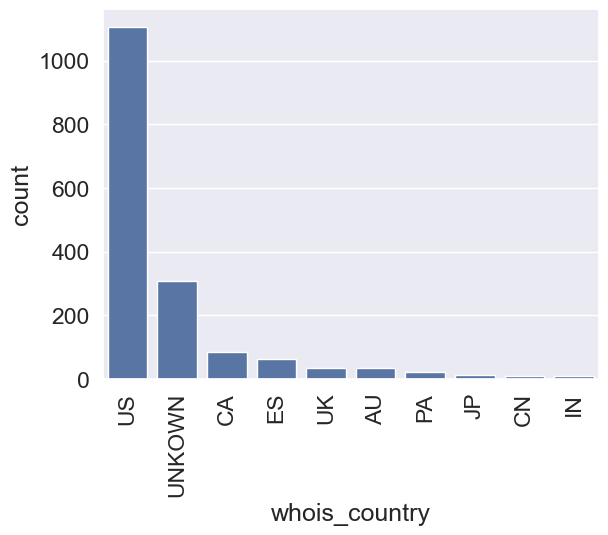

In [19]:
sns.barplot(data=df2["whois_country"].value_counts().head(10), errorbar=None)
plt.xticks(rotation = 90)
plt.show;

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [20]:
countries = list(df2["whois_country"].value_counts().head(11).index)
countries.remove("UNKOWN")
df2["whois_country"] = df2["whois_country"].apply(lambda x: "OTHER" if x not in countries else x)

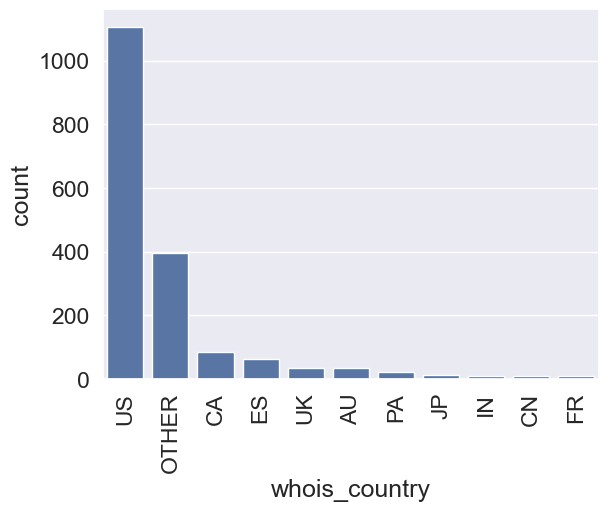

In [21]:
sns.barplot(data=df2["whois_country"].value_counts(), errorbar=None)
plt.xticks(rotation = 90)
plt.show;

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [22]:
df2.drop(columns=["whois_statepro", "whois_regdate", "whois_updated_date"], inplace=True)
df2.sample(5)

,url,number_special_characters,charset,server,whois_country,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_bytes,dns_query_times,type
1011,B0_1188,9,us-ascii,Microsoft-HTTPAPI/2.0,US,0,0,0,0,0,0.0,0
283,M0_165,8,ISO-8859-1,cloudflare-nginx,OTHER,15,1,2,1850,2970,6.0,1
1704,B0_411,19,ISO-8859-1,nginx,US,47,10,10,4284,28130,6.0,0
425,B0_1061,8,utf-8,YouTubeFrontEnd,US,0,0,0,0,0,0.0,0
1090,B0_853,9,ISO-8859-1,Apache,OTHER,0,0,0,0,0,0.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [23]:
df2.dtypes


url                           object
number_special_characters      int64
charset                       object
server                        object
whois_country                 object
tcp_conversation_exchange      int64
dist_remote_tcp_port           int64
remote_ips                     int64
app_bytes                      int64
source_app_bytes               int64
dns_query_times              float64
type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [24]:
df2.drop(columns=["url"], inplace=True)
df2.sample(5)

,number_special_characters,charset,server,whois_country,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_bytes,dns_query_times,type
1751,22,ISO-8859-1,Apache/2.2.15 (CentOS) DAV/2 mod_ssl/2.2.15 Op...,US,70,2,6,5398,137144,4.0,0
1419,13,iso-8859-1,Apache/2.2.15 (CentOS),US,0,0,0,0,0,0.0,0
1414,14,UTF-8,nginx,PA,0,0,0,0,0,0.0,0
679,9,iso-8859-1,Apache,OTHER,9,0,2,870,5876,2.0,0
495,9,UTF-8,Apache,PA,0,0,0,0,0,0.0,0


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [25]:
df2.charset.unique()

array(['iso-8859-1', 'UTF-8', 'us-ascii', 'ISO-8859-1', 'utf-8', 'unkown',
       'windows-1251', 'ISO-8859', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [26]:
df2.server.value_counts()

server
Apache                                                                             386
nginx                                                                              211
unkown                                                                             176
Microsoft-HTTPAPI/2.0                                                              113
cloudflare-nginx                                                                    94
                                                                                  ... 
Apache/2.2.29 (Unix) mod_ssl/2.2.29 OpenSSL/1.0.1e-fips DAV/2 mod_bwlimited/1.4      1
gunicorn/19.7.1                                                                      1
Apache/2.2.31 (Unix) mod_ssl/2.2.31 OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4      1
Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1                  1
Apache/2.2.16 (Debian)                                                               1
Name: count, Length: 239, dtype: int

In [27]:
df2.server.unique()


array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'unkown',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fip

![Think Hard](../images/think-hard.jpg)

In [28]:
# We could use regex to do some binning, and reduce to just a few values like Apache, Microsoft, nginx, unkown ...

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [29]:
df2["server"] = df2["server"].str.replace(".*Apache.*", "Apache", regex = True)
df2["server"] = df2["server"].str.replace(".*nginx.*", "nginx", regex = True)
df2["server"] = df2["server"].str.replace(".*Microsoft.*", "Microsoft", regex = True)
df2["server"] = df2["server"].apply(lambda x: "Other" if x not in ["Apache", "Microsoft", "nginx"] else x)

In [30]:
# Count `SERVER` value counts here
df2.server.value_counts()

server
Apache       643
Other        505
nginx        435
Microsoft    198
Name: count, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [31]:
# Your code here
website_dummy = pd.get_dummies(df2)
website_dummy

,number_special_characters,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_bytes,dns_query_times,type,charset_ISO-8859,charset_ISO-8859-1,...,whois_country_CA,whois_country_CN,whois_country_ES,whois_country_FR,whois_country_IN,whois_country_JP,whois_country_OTHER,whois_country_PA,whois_country_UK,whois_country_US
0,7,7,0,2,700,1153,2.0,1,False,False,...,False,False,False,False,False,False,True,False,False,False
1,6,17,7,4,1230,1265,0.0,0,False,False,...,False,False,False,False,False,False,True,False,False,False
2,6,0,0,0,0,0,0.0,0,False,False,...,False,False,False,False,False,False,True,False,False,False
3,6,31,22,3,3812,18784,8.0,0,False,True,...,False,False,False,False,False,False,False,False,False,True
4,6,57,2,5,4278,129889,4.0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,16,0,0,0,0,186,0.0,1,False,False,...,False,False,True,False,False,False,False,False,False,False
1777,17,0,0,0,0,124,0.0,1,False,False,...,False,False,True,False,False,False,False,False,False,False
1778,34,83,2,6,6631,132181,4.0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
1779,34,0,0,0,0,0,0.0,0,False,True,...,False,False,False,False,False,False,False,False,False,True


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [32]:
# Your code here
website_dummy.dtypes

number_special_characters      int64
tcp_conversation_exchange      int64
dist_remote_tcp_port           int64
remote_ips                     int64
app_bytes                      int64
source_app_bytes               int64
dns_query_times              float64
type                           int64
charset_ISO-8859                bool
charset_ISO-8859-1              bool
charset_UTF-8                   bool
charset_iso-8859-1              bool
charset_unkown                  bool
charset_us-ascii                bool
charset_utf-8                   bool
charset_windows-1251            bool
charset_windows-1252            bool
server_Apache                   bool
server_Microsoft                bool
server_Other                    bool
server_nginx                    bool
whois_country_AU                bool
whois_country_CA                bool
whois_country_CN                bool
whois_country_ES                bool
whois_country_FR                bool
whois_country_IN                bool
w

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [38]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = website_dummy.drop(columns=["type"])
y = website_dummy["type"]

# Separate data into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [40]:
model.fit(X_train, y_train)

c:\Users\FernandoSanz-Extreme\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8543417366946778
[[295  11]
 [ 41  10]]


What are your thoughts on the performance of the model? Write your conclusions below.

In [43]:
# The model has a 85% of accuracy to predict the not malicious websites, but it has a low accuracy to predict the malicious ones

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn3_model = KNeighborsClassifier(n_neighbors=3)
knn3_model = knn3_model.fit(X_train, y_train)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [47]:
predictions3 = knn3_model.predict(X_test)
print(accuracy_score(y_test, predictions3))
print(confusion_matrix(y_test, predictions3))

0.9327731092436975
[[302   4]
 [ 20  31]]


#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [48]:
knn5_model = KNeighborsClassifier(n_neighbors=5)
knn5_model = knn5_model.fit(X_train, y_train)
predictions5 = knn5_model.predict(X_test)
print(accuracy_score(y_test, predictions5))
print(confusion_matrix(y_test, predictions5))

0.9243697478991597
[[300   6]
 [ 21  30]]


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [49]:
# The KNN method yields a better accuracy than the LogisticRegression, but it does worst with 5 neighbors than with 3 neighbors

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here